In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image


In [2]:
# configure DEVICE
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [3]:
#function to add the noise

def add_noise(img, p=0.5):
    assert p > 0 and p < 1, 'The probability value should lie in (0, 1)'
    mask = torch.rand(512, 512)
    img[:, mask<p] = 0
    mask = mask > p
    mask = mask.repeat(3,1,1)
    return img, mask

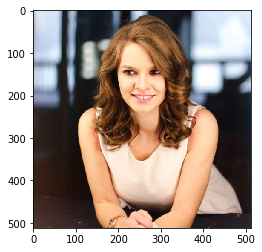

In [4]:
img = Image.open('Data/Inpainting/kate.png')
plt.imshow(img)

to_tensor = transforms.ToTensor()

#original image
img = to_tensor(img)

In [5]:
# function to plot the corrupted image and mask

def plot_priors(x, mask):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(x)
    f.add_subplot(1,2, 2)
    plt.imshow(mask)
    plt.show(block=True)

In [6]:
#add the noise in img and generate noisy image along with the mask for the noise
x, mask = add_noise(img, 0.5)
x = x.unsqueeze(0)
mask = mask.unsqueeze(0)

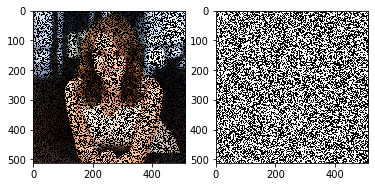

In [7]:
plot_priors(x.squeeze(0).permute(1,2,0), mask.squeeze(0).double().permute(1,2,0))

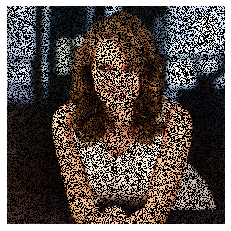

In [8]:
plt.axis('off')
plt.imshow(x.squeeze(0).permute(1,2,0))
plt.savefig("kate_corrupted_5.png", bbox_inches='tight')

#noisy image

In [9]:
#U-Net type architecture with skip connection

class Network(nn.Module):
    def __init__(self, z_size):
        super(Network,self).__init__()

        self.leaky_relu = nn.LeakyReLU()

        self.d_conv_1 = nn.Conv2d(z_size, 8, 5, stride=2, padding=2)
        self.d_bn_1 = nn.BatchNorm2d(8)

        self.d_conv_2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.d_bn_2 = nn.BatchNorm2d(16)

        self.d_conv_3 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.d_bn_3 = nn.BatchNorm2d(32)
        self.s_conv_3 = nn.Conv2d(32, 4, 5, stride=1, padding=2)

        self.d_conv_4 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.d_bn_4 = nn.BatchNorm2d(64)
        self.s_conv_4 = nn.Conv2d(64, 4, 5, stride=1, padding=2)

        self.d_conv_5 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.d_bn_5 = nn.BatchNorm2d(128)
        self.s_conv_5 = nn.Conv2d(128, 4, 5, stride=1, padding=2)

        self.d_conv_6 = nn.Conv2d(128, 256, 5, stride=2, padding=2)
        self.d_bn_6 = nn.BatchNorm2d(256)

        self.u_deconv_5 = nn.ConvTranspose2d(256, 124, 4, stride=2, padding=1)
        self.u_bn_5 = nn.BatchNorm2d(128)

        self.u_deconv_4 = nn.ConvTranspose2d(128, 60, 4, stride=2, padding=1)
        self.u_bn_4 = nn.BatchNorm2d(64)

        self.u_deconv_3 = nn.ConvTranspose2d(64, 28, 4, stride=2, padding=1)
        self.u_bn_3 = nn.BatchNorm2d(32)

        self.u_deconv_2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.u_bn_2 = nn.BatchNorm2d(16)

        self.u_deconv_1 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.u_bn_1 = nn.BatchNorm2d(8)

        self.out_deconv = nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1)
        self.out_bn = nn.BatchNorm2d(3)

    def forward(self, noise):
        down_1 = self.d_conv_1(noise)
        down_1 = self.d_bn_1(down_1)
        down_1 = self.leaky_relu(down_1)

        down_2 = self.d_conv_2(down_1)
        down_2 = self.d_bn_2(down_2)
        down_2 = self.leaky_relu(down_2)

        down_3 = self.d_conv_3(down_2)
        down_3 = self.d_bn_3(down_3)
        down_3 = self.leaky_relu(down_3)
        skip_3 = self.s_conv_3(down_3)

        down_4 = self.d_conv_4(down_3)
        down_4 = self.d_bn_4(down_4)
        down_4 = self.leaky_relu(down_4)
        skip_4 = self.s_conv_4(down_4)

        down_5 = self.d_conv_5(down_4)
        down_5 = self.d_bn_5(down_5)
        down_5 = self.leaky_relu(down_5)
        skip_5 = self.s_conv_5(down_5)

        down_6 = self.d_conv_6(down_5)
        down_6 = self.d_bn_6(down_6)
        down_6 = self.leaky_relu(down_6)

        up_5 = self.u_deconv_5(down_6)
        up_5 = torch.cat([up_5, skip_5], 1)
        up_5 = self.u_bn_5(up_5)
        up_5 = self.leaky_relu(up_5)

        up_4 = self.u_deconv_4(up_5)
        up_4 = torch.cat([up_4, skip_4], 1)
        up_4 = self.u_bn_4(up_4)
        up_4 = self.leaky_relu(up_4)

        up_3 = self.u_deconv_3(up_4)
        up_3 = torch.cat([up_3, skip_3], 1)
        up_3 = self.u_bn_3(up_3)
        up_3 = self.leaky_relu(up_3)

        up_2 = self.u_deconv_2(up_3)
        up_2 = self.u_bn_2(up_2)
        up_2 = self.leaky_relu(up_2)

        up_1 = self.u_deconv_1(up_2)
        up_1 = self.u_bn_1(up_1)
        up_1 = self.leaky_relu(up_1)

        out = self.out_deconv(up_1)
        out = self.out_bn(out)
        out = nn.Sigmoid()(out)

        return out

In [10]:
#latent matrix choosen as per the directions given in supplementry material provided by the author

latent_matrix = np.mgrid[:512, :512]/512
print(type(latent_matrix))
latent_matrix = torch.from_numpy(latent_matrix)



#Hyper parameters
z = latent_matrix.unsqueeze(0)
z = z.double()
device = 'cpu'
num_epochs = 7000
lr = 0.02
z_size = z.shape[1]


model = Network(z_size)
model = model.float()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
print(z_size)

z

<class 'numpy.ndarray'>
2


tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.9941, 0.9941, 0.9941,  ..., 0.9941, 0.9941, 0.9941],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9980, 0.9980, 0.9980,  ..., 0.9980, 0.9980, 0.9980]],

         [[0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980],
          [0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980],
          [0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980],
          ...,
          [0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980],
          [0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980],
          [0.0000, 0.0020, 0.0039,  ..., 0.9941, 0.9961, 0.9980]]]],
       dtype=torch.float64)

In [11]:
#move the tensors to device

model = model.to(device)
z = z.to(device)
x = x.to(device)
mask = mask.to(device)

In [12]:
#Training 

losses = []
images = []

for i in range(3000):
    model.zero_grad()
    out = model(z.float())
    loss = criterion(x, out*mask)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    
    if (i+1)%50 ==0:
        out = model(z.float())
        images.append(out.squeeze(0).permute(1,2,0))
        
    if (i+1)%100 == 0:
        print('Epoch : {} , Error : {}'.format(i+1, loss))   

In [13]:
out = model(z.float())
out.shape
plt.axis('off')
plt.imshow(out.detach().squeeze(0).permute(1,2,0))

#model output
plt.savefig("Results/Denoising/recovered_kate.png", bbox_inches='tight')

In [14]:
#plotting the loss

plt.plot(losses)
plt.show()